In [1]:
# training visualization
# %load_ext tensorboard

import os
import pickle
#for python typing
from typing import Dict, Optional, Callable
from functools import partial

# for math operations
import math
import random

import numpy as np

# ML packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torchsummary import summary

# training visualization
# from tqdm import trange
import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter

# impelementations
from autoencoders import ResNetAutoEncoder
from prototypical_network import ClassificationDataset, Convnet

state = 42
torch.manual_seed(state)
torch.cuda.manual_seed(state)
np.random.seed(state)
random.seed(state)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

/home/woreom/miniconda3/envs/few/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_bird_dataset(path: str= "../../datasets/birds/",
                        mode: str= "train") -> torch.utils.data.Dataset:
    
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Resize((96,96)),
         # transforms.Normalize((0.5), (0.5))
        ])

    # transform = transforms.ToTensor()

    dataset = datasets.ImageFolder(path+f'/{mode}/',
                                        transform=transform)
    
    return dataset

def get_mini_magenet(root: str, mode: str, transform: Optional[Callable] = None, download: bool= False,
                     target_transform: Optional[Callable] = None) -> torch.utils.data.Dataset:
    """Mini ImageNet Dataset Loader for torch"""
    
    gdrive_id = {"test":'1wpmY-hmiJUUlRBkO9ZDCXAcIpHEFdOhD', "train":'1I3itTXpXxGV68olxM5roceUMG8itH9Xj',
                 "val":'1KY5e491bkLFqJDp0-UWou3463Mo8AOco'}
    
    pickle_file = os.path.join(root, f'mini-imagenet_{mode}.pkl')
    
    # download pkl file
    if not os.path.exists(pickle_file) and download:
        print(f"Downloading mini-imagenet_{model} at {pickle_file}")
        download_from_gdrive(_id=MiniImagenet.gdrive_id[mode], output=pickle_file)
        
    # open pkl file
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    
    # create X and y
    X = torch.from_numpy(data["image_data"]).permute(0, 3, 1, 2).float()
    y = np.ones(X.shape[0])

    # dict of indexes to np.array
    for (i, key) in enumerate(data['class_dict'].keys()):
        for idx in data['class_dict'][key]:
            y[idx] = i

    return ClassificationDataset(X= X, y= y, transform= transform,
                                 target_transform= target_transform)

def check_loader(dataset: torch.utils.data.Dataset, grid_split: int= 10, num_img: int= 30) -> None:
    # label_mapping = {y: x for x, y in dataset.class_to_idx.items()}

    fraction = math.ceil(num_img/grid_split)
    width = grid_split if fraction != 0 else num_img
    height = fraction if  width == grid_split else 1

    figure = plt.figure(figsize=(width, height))
    for i, (img, label) in enumerate(dataset):
        if i==0: print(f"image.shape: {img.shape}")
        elif i>=num_img: break
        
        figure.add_subplot(height, width, i+1)
        # plt.title(label_mapping[label], fontsize=4)
        plt.title(label, fontsize=4)
        plt.axis("off")
        plt.imshow(img[0].numpy(), cmap="gray")

image.shape: torch.Size([3, 96, 96])


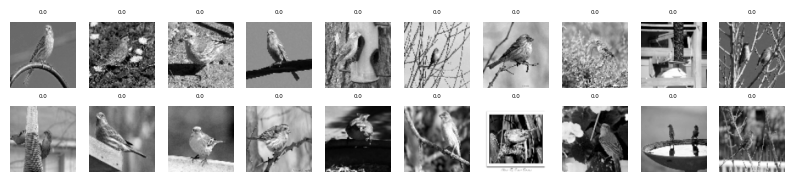

In [9]:
transform = transforms.Compose([
    transforms.Resize((96,96)),
    ])

dataset = get_mini_magenet(mode= 'train', root="../../datasets/mini_imagenet_temp/",
                      transform=transform, target_transform=None, download=False)

check_loader(dataset= dataset, grid_split=10, num_img=20)

# ResNet AutoEncoder

In [4]:
autoencoder = ResNetAutoEncoder(arch= "test", num_workers=5,
                                batch_size=128, eval_step=5)

_input = torch.randn((5,3,96,96))

print(f"encoder output: {_input.shape}")

output = autoencoder.encoder(_input)

print(f"encoder output: {output.shape}")

output = autoencoder.decoder(output)

print(f"decoder output: {output.shape}")

autoencoder.encoder.cuda()
autoencoder.decoder.cuda()

print(summary(autoencoder.encoder,(3,96,96)))
print(summary(autoencoder.decoder,(512, 3, 3)))

encoder output: torch.Size([5, 3, 96, 96])
encoder output: torch.Size([5, 512, 3, 3])
decoder output: torch.Size([5, 3, 96, 96])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
EncoderResidualLayer-11           [-1, 64, 24, 24]               0
EncoderResidualBlock-12           [

In [11]:
test = torch.load("../outputs/exported/resnet_autoencoder/caltech256-resnet18.pth")
autoencoder.state_dict(test['state_dict'])

/home/woreom/anaconda3/envs/few/lib/python3.8/site-packages/torch/nn/modules/module.py:1365: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


KeyboardInterrupt: 

Epoch 25: 100%|██████████| 18/18 [00:05<00:00,  3.57batch/s, loss=0.00673, mode=test]


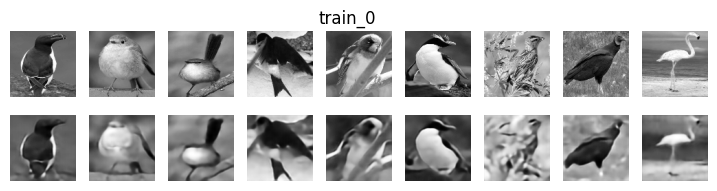

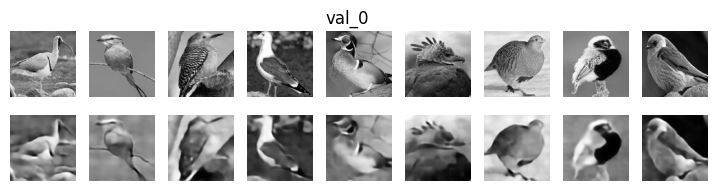

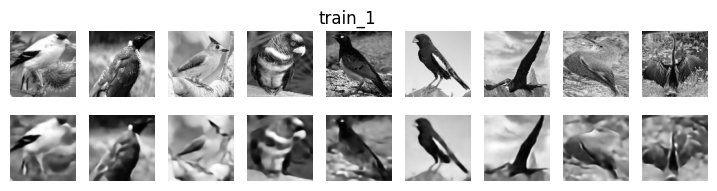

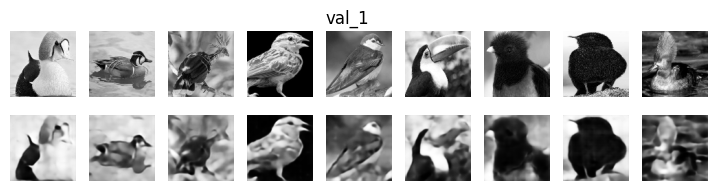

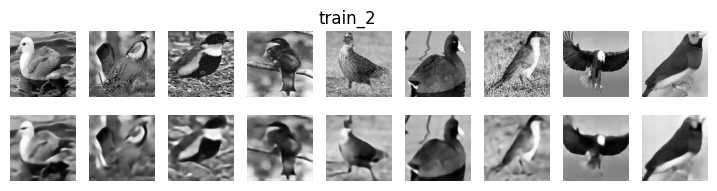

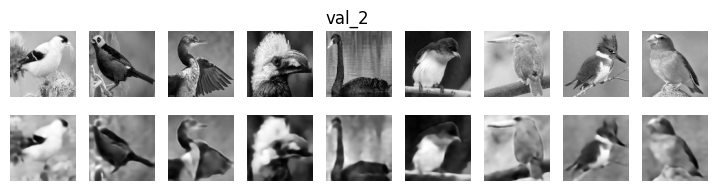

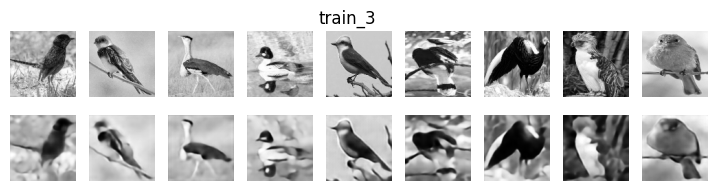

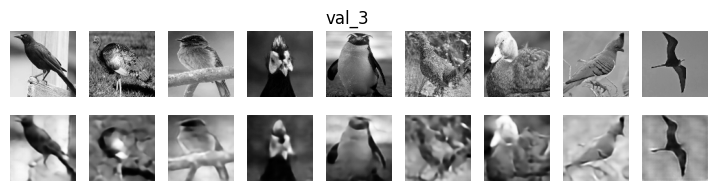

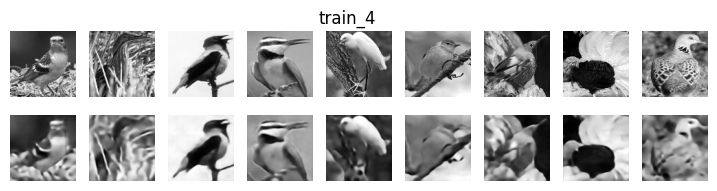

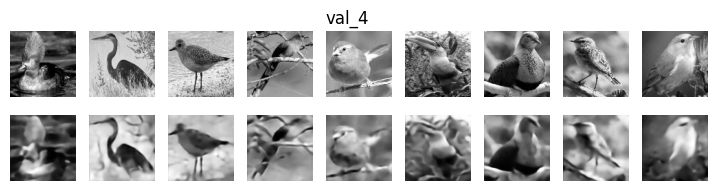

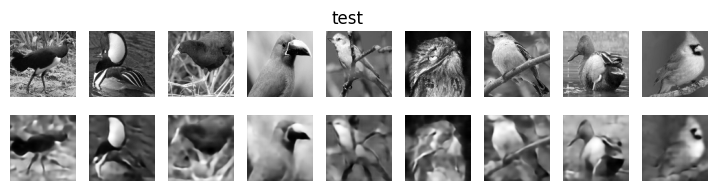

In [3]:
# autoencoder = ResNetAutoEncoder(arch= "test", num_workers=5,
#                                 batch_size=128, eval_step=1)

autoencoder = torch.load("../outputs/exported/resnet_autoencoder/4m.pt")
autoencoder.eval()
autoencoder.eval_step=5

loss = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

get_dataset = partial(get_bird_dataset, path="../../datasets/birds/")

autoencoder.fit(dataset=get_dataset, optimizer=optimizer, loss=loss, num_epochs=25)

In [5]:
torch.save(autoencoder, "../outputs/exported/resnet_autoencoder/4m_2.pt")

In [ ]:
model = torch.load("../outputs/exported/resnet_autoencoder/4m.pt")
model.eval()

ResNetAutoEncoder(
  (encoder): ResNetEncoder(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): EncoderResidualBlock(
      (00 MaxPooling): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (01 EncoderLayer): EncoderResidualLayer(
        (weight_layer1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (weight_layer2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): Sequential(
 

In [ ]:
model.eval_step=50

In [ ]:
def conv3x3(in_planes, out_planes):
    return nn.Conv2d(in_planes, out_planes, 3, padding=1, bias=False)


def conv1x1(in_planes, out_planes):
    return nn.Conv2d(in_planes, out_planes, 1, bias=False)


def norm_layer(planes):
    return nn.BatchNorm2d(planes)


class Block(nn.Module):

    def __init__(self, inplanes, planes, downsample):
        super().__init__()

        self.relu = nn.LeakyReLU(0.1)

        self.conv1 = conv3x3(inplanes, planes)
        self.bn1 = norm_layer(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.conv3 = conv3x3(planes, planes)
        self.bn3 = norm_layer(planes)

        self.downsample = downsample

        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        out = self.maxpool(out)

        return out


class ResNet12(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.inplanes = 3

        self.layer1 = self._make_layer(channels[0])
        self.layer2 = self._make_layer(channels[1])
        self.layer3 = self._make_layer(channels[2])
        self.layer4 = self._make_layer(channels[3])

        self.out_dim = channels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                        nonlinearity='leaky_relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, planes):
        downsample = nn.Sequential(
            conv1x1(self.inplanes, planes),
            norm_layer(planes),
        )
        block = Block(self.inplanes, planes, downsample)
        self.inplanes = planes
        return block

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.shape[0], x.shape[1], -1).mean(dim=2)
        return x


def resnet12():
    return ResNet12([64, 128, 256, 512])


In [ ]:
alexnet =ResNetAutoEncoder(arch= "test", num_workers=5,
                                batch_size=128, eval_step=5)
alexnet.encoder.cuda()
summary(alexnet.encoder, (3, 224, 224))

RuntimeError: Given groups=1, weight of size [512, 256, 3, 3], expected input[2, 64, 56, 56] to have 256 channels, but got 64 channels instead

In [ ]:
alexnet =resnet12()
alexnet.cuda()
summary(alexnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
         LeakyReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
         LeakyReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,864
       BatchNorm2d-8         [-1, 64, 224, 224]             128
            Conv2d-9         [-1, 64, 224, 224]             192
      BatchNorm2d-10         [-1, 64, 224, 224]             128
        LeakyReLU-11         [-1, 64, 224, 224]               0
        MaxPool2d-12         [-1, 64, 112, 112]               0
            Block-13         [-1, 64, 112, 112]               0
           Conv2d-14        [-1, 128, 1